# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 1: Analyze Paths</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna.</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type.</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network.</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides.</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density.</li>
    <li>Analyze traffic-density per area during different times of the day.</li>

<img src="../artifacts/img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<left>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </left>

### 1 Imports
***

In [1]:
import os
import pickle
import sys

root = os.environ['HOME']+"/private/vienna-traffic-density/"
sys.path.append(root)

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as Centroid

import params.config as conf
from src.network_paths import NetworkPath
from src.utils import plot_graph

### 2 Areas
***

In [2]:
areas_path = os.path.join(conf.root_output, "pkl", "areas.pkl")
streets_path = os.path.join(conf.root_output, "pkl", "streets.pkl")
network_path = os.path.join(conf.root_output, "pkl", "network.pkl")

with open(areas_path, 'rb') as f:
    areas = pickle.load(f)

with open(streets_path, 'rb') as f:
    streets = pickle.load(f)

with open(network_path, 'rb') as f:
    network = pickle.load(f)

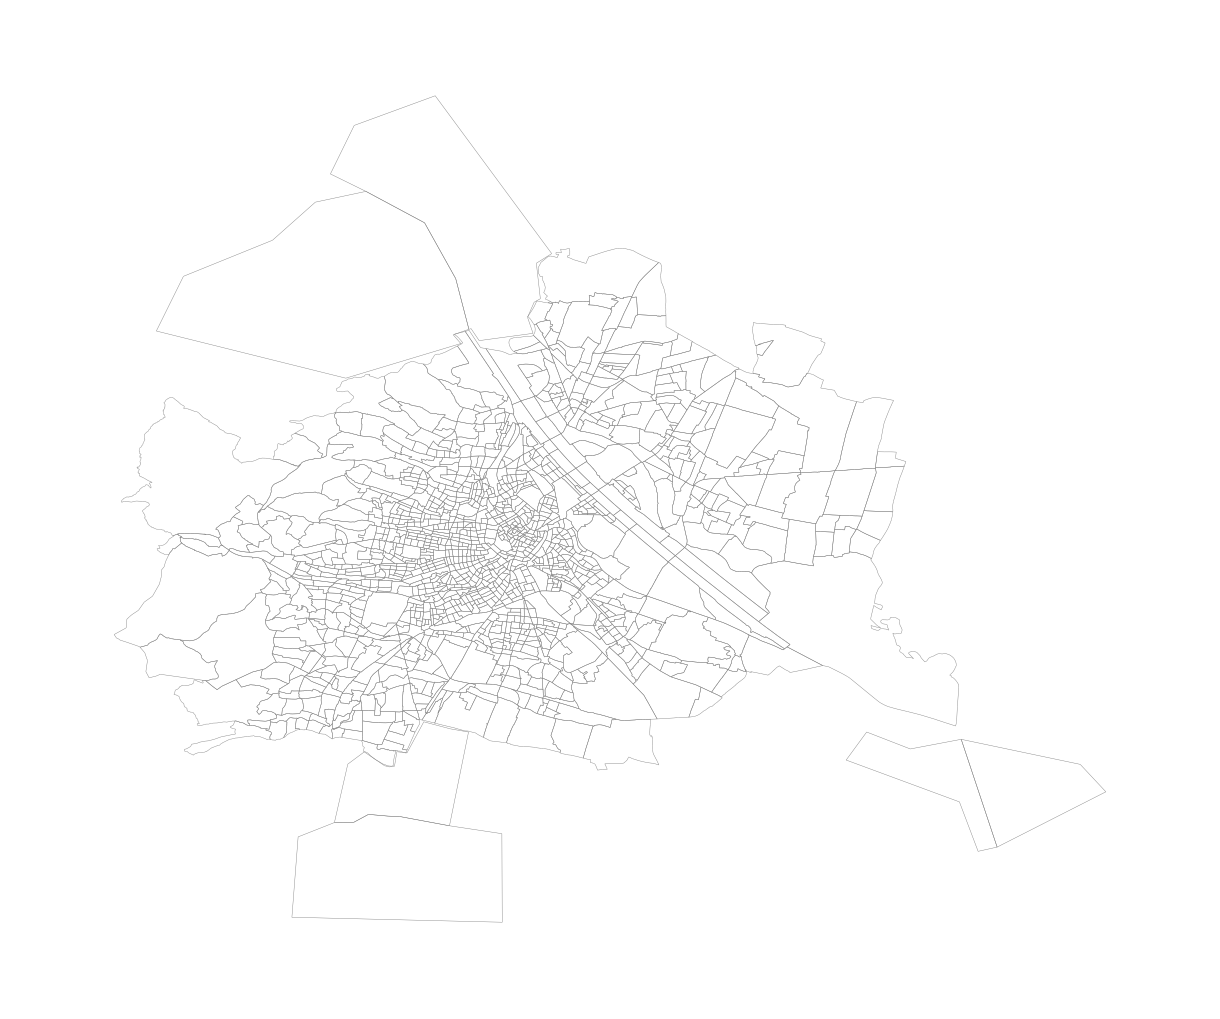

In [3]:
Vienna = nx.Graph()

plot_graph(
    G=areas.graph, 
    pos=areas.pos, 
    colors="grey",
    filename="areas.png"
)

### 3 Streets
***

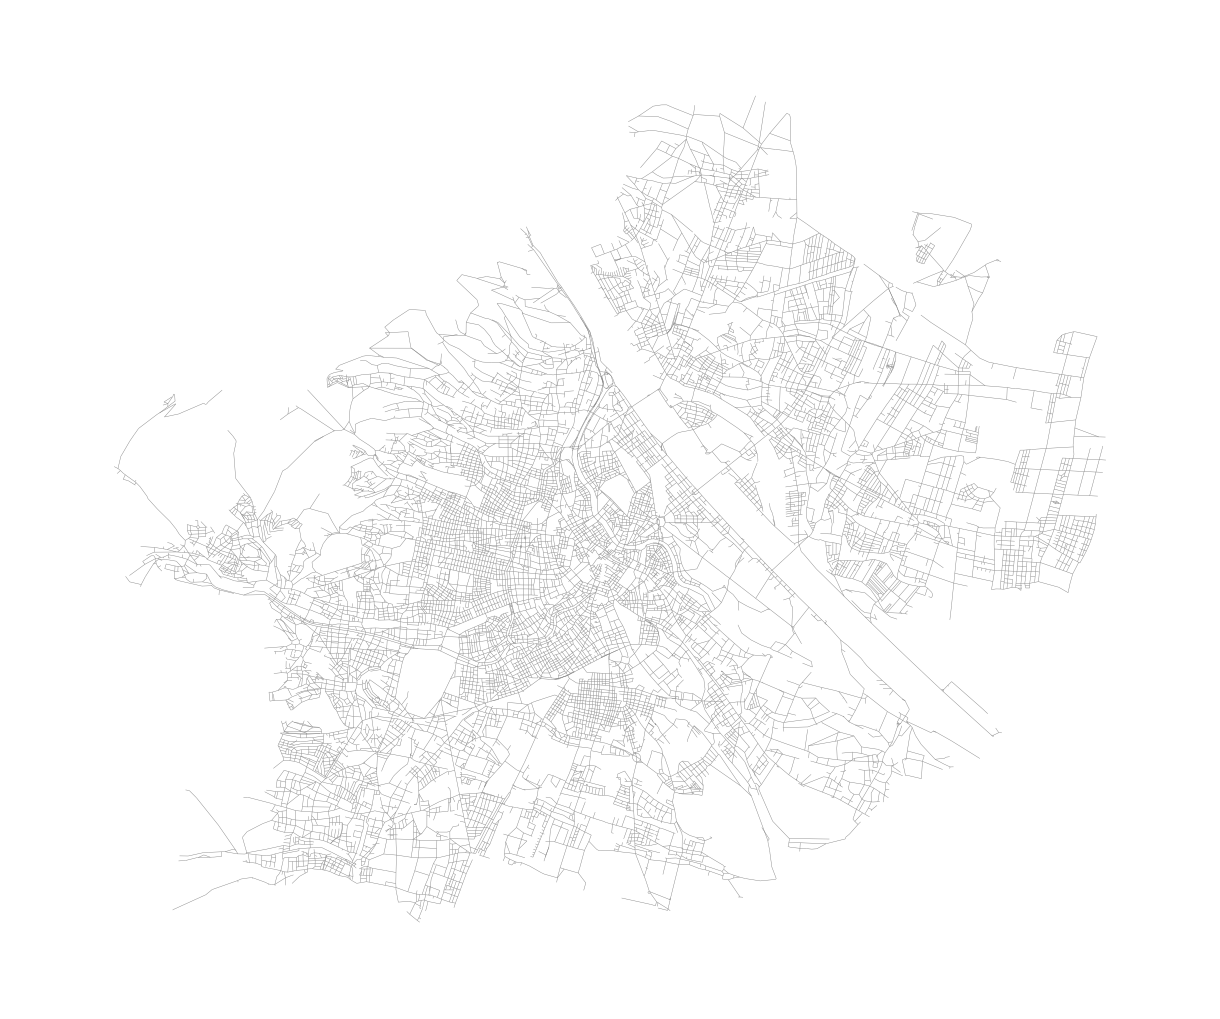

In [4]:
plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors="gray", 
    filename="streets.png"
)

In [5]:
rand_edge = network.random_edge()
rand_node = network.random_node()

print ("Network-Edges:")
display (network.G.edges[rand_edge])

print ("Network-Nodes:")
display (network.G.nodes[rand_node])

Network-Edges:


{'STREET_NAME': 'An der Niederhaid',
 'DISTRICT': '14',
 'DISTANCE': 90.620975368919,
 'SPEED': 30,
 'TRAVEL_TIME': 10.87451704427028,
 'STREET_TYPE': 'local-street',
 'AREA_FROM': '0371',
 'AREA_TO': '0371'}

Network-Nodes:


{'AREA': '0799'}

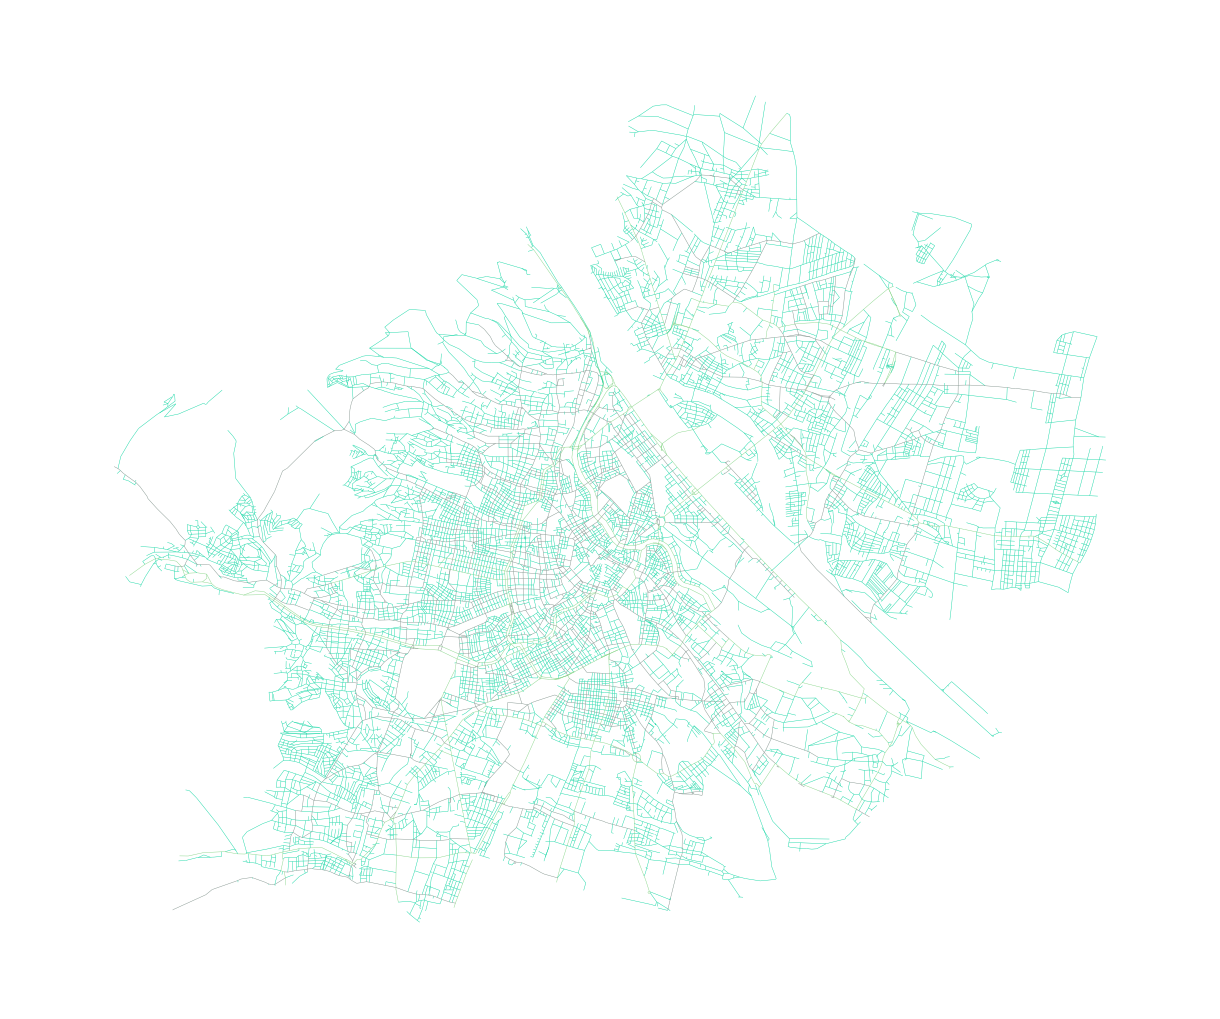

In [6]:
network.color_by_attr(
    edges=streets.edges, 
    attr="STREET_TYPE"
)
plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors=network.colors, 
    filename="streets-type.png"
)

### 4 Paths
***

In [7]:
start_node = network.random_node()
end_node = network.random_node()

print (f"Start-node: {start_node}")
print (f"End-node: {end_node}")

Start-node: 10346749
End-node: 10357288


In [8]:
path = NetworkPath()
path.shortest_path(
    G=network.G,
    start_node=start_node, 
    end_node=end_node,
    metric="TRAVEL_TIME"
)

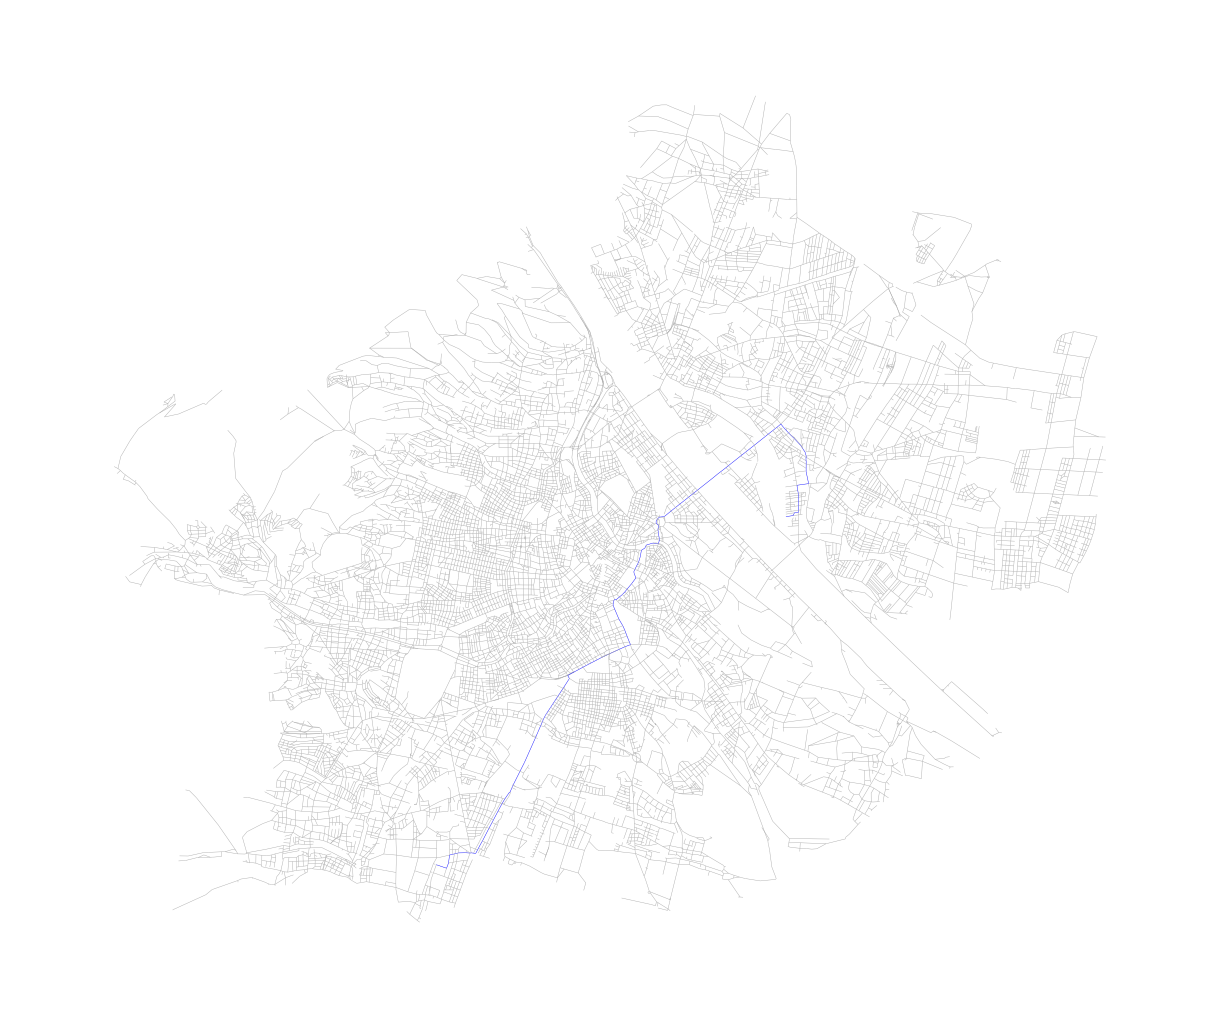

In [9]:
network.color_by_path(
    path=path.edges, 
    color="blue", 
)
plot_graph(
    G=network.G, 
    pos=streets.pos, 
    colors=network.colors,
    filename="streets-path.png"
)

In [10]:
path.get_summary(G=network.G)

{'EST_CROSSINGS': 178,
 'EST_DISTANCE': 20343.035558842297,
 'EST_TRAVEL_TIME': 1226.4840446307978}

In [11]:
print ("Network-Nodes of Path:")
display (path.nodes[:10])

print ("Network-Edges of Path:")
display (path.edges[:10])

Network-Nodes of Path:


[10346749,
 10346798,
 10346797,
 10346739,
 10346738,
 10346737,
 10346736,
 10346718,
 10346735,
 10346734]

Network-Edges of Path:


[(10346798, 10346749),
 (10346798, 10346797),
 (10346739, 10346797),
 (10346739, 10346738),
 (10346738, 10346737),
 (10346736, 10346737),
 (10346718, 10346736),
 (10346718, 10346735),
 (10346734, 10346735),
 (10346759, 10346734)]

In [12]:
area_counts   = path.get_areas_count(G=network.G)
area_distance = path.get_areas_by_metric(G=network.G, metric="DISTANCE")
area_time     = path.get_areas_by_metric(G=network.G, metric="TRAVEL_TIME")

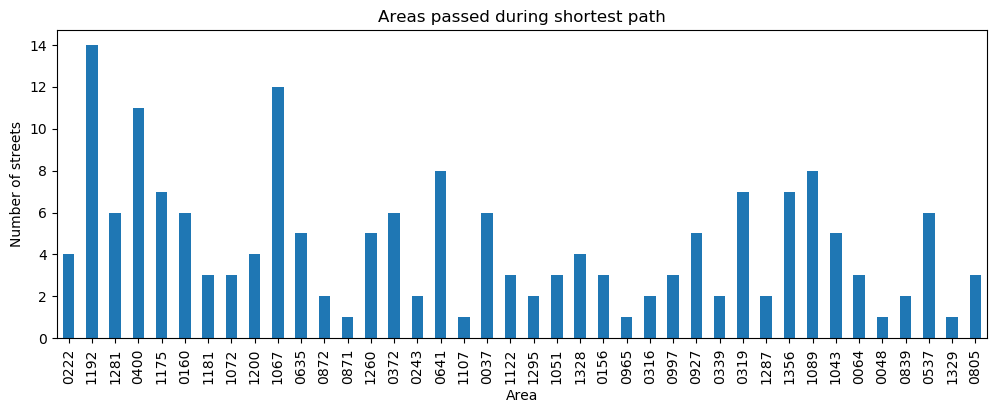

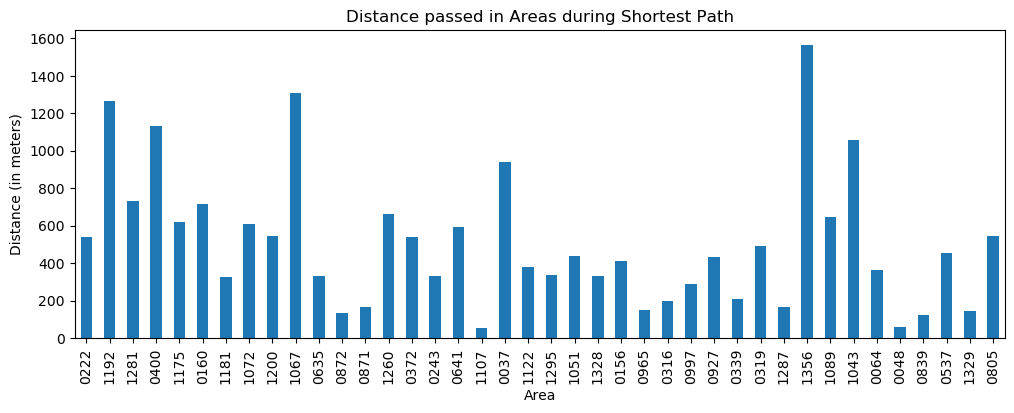

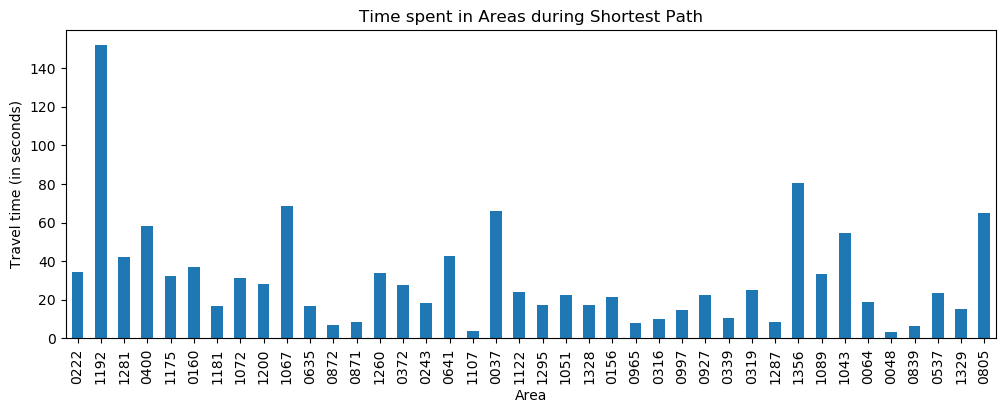

In [13]:
plt.figure(figsize=(12,4))
area_counts.plot.bar( 
    ylabel="Number of streets", 
    xlabel="Area",
    title="Areas passed during shortest path"
)

plt.figure(figsize=(12,4))
pd.Series(area_distance).plot.bar(
    ylabel="Distance (in meters)", 
    xlabel="Area",
    title="Distance passed in Areas during Shortest Path"
)

plt.figure(figsize=(12,4))
pd.Series(area_time).plot.bar(
    ylabel="Travel time (in seconds)",
    xlabel="Area",
    title="Time spent in Areas during Shortest Path", 
)
plt.show()

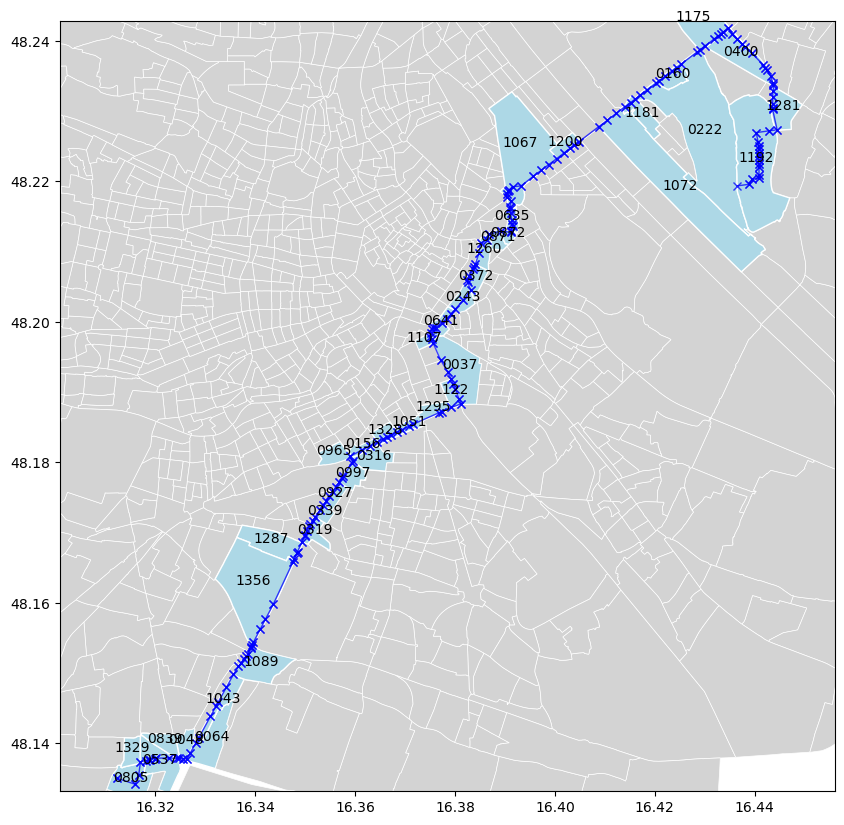

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

path.get_limits(nodes=streets.nodes)
ax.set_xlim(path.xlim)
ax.set_ylim(path.ylim)

for key,val in areas.polygons.items():
    
    # Plot gray areas
    ax.add_patch(Polygon(val, 
        closed=True, 
        facecolor="lightgray", 
        edgecolor="white",
        linewidth=0.5))
    
    # Plot red areas
    if key in path.areas_set: 
        ax.add_patch(Polygon(val,
            closed=True, 
            facecolor="lightblue", 
            edgecolor="white",
            linewidth=1))
        
        x_center, y_center = Centroid(val).centroid.coords[0]
        ax.text(x=x_center, y=y_center, s=key, ha="center")


# Plot edges of path
for i in range(len(path.nodes)):
    ax.plot(path.x_coords[i:i+2], 
            path.y_coords[i:i+2], 
            linewidth=1, 
            color="blue",
            alpha=0.75,
            marker="x", 
            markersize=6, 
            mfc="blue")

plt.savefig(conf.root_img+"/areas-path.png", dpi=600)
plt.show()